### Training CaDRReS model and use the model for predicting drug response

This example shows how to predicting drug respons using the GDSC model. Input file is a gene exression matrix.

1. Normalize gene expression
2. Choose model specification and train a model using full dataset (use CCLE as an example).
3. Train CaDRRReS model

#### Read gene expression file and calculate kernel features


In [119]:
import sys, os, pickle
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
from collections import Counter
import importlib

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

scriptpath = '..'
sys.path.append(os.path.abspath(scriptpath))

from cadrres import pp, model, evaluation, utility

In [120]:
drug_set_name = 'drug' # hn_drug | drug
indication_name = 'HNSC'
weight_type = 'dwsim10' # dw1 | dw10 | dwsim10
dw_degree = 10

output_dir = '../result/HN_model/'

##### Read drug info

In [121]:
gdsc_sample_df = pd.read_csv('../data/GDSC/GDSC_tissue_info.csv', index_col=0)
gdsc_sample_df.index = gdsc_sample_df.index.astype(str)

gdsc_sample_list = pd.read_csv('../data/GDSC/gdsc_all_abs_ic50_bayesian_sigmoid_only9dosages.csv', index_col=0).index.astype(str)

indication_sample_list = [u for u in gdsc_sample_df[gdsc_sample_df['TCGA_CLASS']==indication_name].index if u in gdsc_sample_list]

len(gdsc_sample_list), len(indication_sample_list)

(1074, 42)

In [122]:
gdsc_drug_df = pd.read_csv('../preprocessed_data/GDSC/{}_stat.csv'.format(drug_set_name), index_col=0)
gdsc_drug_df.index = gdsc_drug_df.index.astype(str)
drug_list = gdsc_drug_df.index
gdsc_drug_df.shape

(226, 27)

##### Normalize gene expression and calculate kernel feature based on GDSC sample

Normalized each gene based on all 1,018 GDSC cell lines

In [123]:
gdsc_log2_exp_df = pd.read_csv('../data/GDSC/GDSC_exp.tsv', sep='\t', index_col=0)
gdsc_log2_exp_df.shape

(17737, 1018)

In [124]:
gdsc_norm_exp_df, gdsc_mean_exp_df = pp.gexp.normalize_log2_mean_fc(gdsc_log2_exp_df)

In [125]:
ess_gene_list = utility.get_gene_list('../data/essential_genes.txt')

gdsc_gene_list = list(gdsc_log2_exp_df.index)
selected_gene_list = [g for g in ess_gene_list if g in gdsc_gene_list]
len(selected_gene_list)

1610

Calculate kernel feature based on all 985 GDSC samples with both gene expression and drug response profiles

In [126]:
# train_feature_df = pp.gexp.calculate_kernel_feature(gdsc_norm_exp_df, gdsc_norm_exp_df, selected_gene_list)
# train_feature_df.shape

In [127]:
# gdsc_sample_list = [s for s in gdsc_sample_list if s in train_feature_df.index]

# train_feature_df = train_feature_df.loc[gdsc_sample_list, gdsc_sample_list]
# print (train_feature_df.shape)

In [128]:
# train_feature_df.to_csv('../preprocessed_data/HN_model/train_feature_df.csv')

In [129]:
# TEMPORARY
train_feature_df = pd.read_csv('../preprocessed_data/HN_model/train_feature_df.csv', index_col=0)
train_feature_df.index = train_feature_df.index.astype(str)

#### Read drug response

In [130]:
gdsc_obs_df = pd.read_csv('../data/GDSC/gdsc_all_abs_ic50_bayesian_sigmoid_only9dosages.csv', index_col=0)
gdsc_obs_df.index = gdsc_obs_df.index.astype(str)
gdsc_obs_df = gdsc_obs_df[drug_list]
gdsc_obs_df.shape

(1074, 226)

In [131]:
train_resp_df = gdsc_obs_df

In [132]:
train_sample_list = list(set(train_resp_df.index).intersection(train_feature_df.index))
len(train_sample_list)

985

1372 Tramitinib was tested for 5 dosages

In [133]:
# tested_drug_list = ['1032', '201', '182', '1007', '1372', '301', '302']
# print ([d for d in tested_drug_list if d in drug_list])

##### Prepare x0 for calculating logistic sample weight

In [134]:
sample_weights_logistic_x0_df = model.get_sample_weights_logistic_x0(gdsc_drug_df, 'log2_max_conc', train_sample_list)
sample_weights_logistic_x0_df.head()

Drug ID,1,1001,1003,1004,1005,1006,1007,1008,1009,1010,...,64,71,83,86,87,88,89,9,91,94
1299081,1.0,10.965784,-3.321928,-3.321928,2.584963,1.0,-6.321928,-2.321928,3.321928,-1.0,...,2.0,4.321928,0.263034,0.034216,-1.965784,2.321928,2.321928,0.0,2.321928,3.321928
713899,1.0,10.965784,-3.321928,-3.321928,2.584963,1.0,-6.321928,-2.321928,3.321928,-1.0,...,2.0,4.321928,0.263034,0.034216,-1.965784,2.321928,2.321928,0.0,2.321928,3.321928
906863,1.0,10.965784,-3.321928,-3.321928,2.584963,1.0,-6.321928,-2.321928,3.321928,-1.0,...,2.0,4.321928,0.263034,0.034216,-1.965784,2.321928,2.321928,0.0,2.321928,3.321928
1290814,1.0,10.965784,-3.321928,-3.321928,2.584963,1.0,-6.321928,-2.321928,3.321928,-1.0,...,2.0,4.321928,0.263034,0.034216,-1.965784,2.321928,2.321928,0.0,2.321928,3.321928
907268,1.0,10.965784,-3.321928,-3.321928,2.584963,1.0,-6.321928,-2.321928,3.321928,-1.0,...,2.0,4.321928,0.263034,0.034216,-1.965784,2.321928,2.321928,0.0,2.321928,3.321928


##### Prepare indication weight

OPTION 1: indication specific weight

In [135]:
if weight_type in ['dw1', 'dw10']:
    indication_weight_df = pd.DataFrame(np.ones(train_resp_df.shape), index=train_resp_df.index, columns=train_resp_df.columns)
    indication_weight_df.loc[indication_sample_list, :] = indication_weight_df.loc[indication_sample_list, :] * dw_degree
    print (len(indication_sample_list))

OPTION 2: similarity-based weigth

In [136]:
if weight_type in ['dwsim10']:

    input_kernel_df = pd.read_csv('../result/HN_model/TMM/cluster_kernel_df.csv', index_col=0)[train_feature_df.columns]

    similarity_df = np.matmul(input_kernel_df, train_feature_df.T).sum().sort_values(ascending=False)
    sim_sample_list = similarity_df.head(100).index
    print (len(sim_sample_list))

    indication_weight_df = pd.DataFrame(np.ones(train_resp_df.shape), index=train_resp_df.index, columns=train_resp_df.columns)
    indication_weight_df.loc[sim_sample_list, :] = indication_weight_df.loc[sim_sample_list, :] * dw_degree

100


In [137]:
indication_weight_df.sum(axis=1).sort_values()

1240121     226.0
907176      226.0
907268      226.0
907269      226.0
907270      226.0
            ...  
906855     2260.0
1240210    2260.0
910710     2260.0
1327771    2260.0
908147     2260.0
Length: 1074, dtype: float64

##### Align sample and drug orders

In [138]:
train_resp_df = train_resp_df.loc[train_sample_list, drug_list]
train_feature_df = train_feature_df.loc[train_sample_list]
logistic_x0_df = sample_weights_logistic_x0_df.loc[train_sample_list, drug_list]
indication_weight_df = indication_weight_df.loc[train_sample_list, drug_list]

#### Train CaDRReS models

For targeted drugs

In [139]:
importlib.reload(pp)
importlib.reload(model)
importlib.reload(evaluation)
importlib.reload(utility)

<module 'cadrres.utility' from '/mnt/volume1/Dropbox/Research/2019_drug_response_heterogeneity/CaDRReS_depository/cadrres/utility.py'>

In [140]:
model_name = '{}_cw_{}_100000'.format(drug_set_name, weight_type)
model_name

'drug_cw_dwsim10_100000'

In [141]:
cadrres_model_dict, cadrres_output_dict = model.train_model_logistic_weight(train_resp_df[drug_list], train_feature_df, train_resp_df[drug_list], train_feature_df, logistic_x0_df[drug_list], indication_weight_df[drug_list], 10, 0.0, 100000, 0.01, save_interval=5000, output_dir=output_dir)

Getting data ...
Initializing the model ...
Train: 180239 out of 222610
Starting model training ...
TF session started ...
Starting 1st iteration ...
MSE train at step 0: 62.531 (0.01m)
MSE train at step 5000: 14.575 (2.47m)
MSE train at step 10000: 8.081 (4.87m)
MSE train at step 15000: 6.765 (7.32m)
MSE train at step 20000: 6.199 (9.71m)
MSE train at step 25000: 5.864 (12.17m)
MSE train at step 30000: 5.637 (14.57m)
MSE train at step 35000: 5.467 (17.04m)
MSE train at step 40000: 5.319 (19.45m)
MSE train at step 45000: 5.202 (21.92m)
MSE train at step 50000: 5.086 (24.34m)
MSE train at step 55000: 4.993 (26.79m)
MSE train at step 60000: 4.908 (29.19m)
MSE train at step 65000: 4.829 (31.65m)
MSE train at step 70000: 4.759 (34.06m)
MSE train at step 75000: 4.689 (36.54m)
MSE train at step 80000: 4.627 (38.94m)
MSE train at step 85000: 4.572 (41.40m)
MSE train at step 90000: 4.521 (43.83m)
MSE train at step 95000: 4.474 (46.28m)
Saving model parameters and predictions ...
DONE


In [142]:
# example model name: hn_drug_cw_dw10_100000
pickle.dump(cadrres_model_dict, open(output_dir + '{}_param_dict.pickle'.format(model_name), 'wb'))
pickle.dump(cadrres_output_dict, open(output_dir + '{}_output_dict.pickle'.format(model_name), 'wb'))

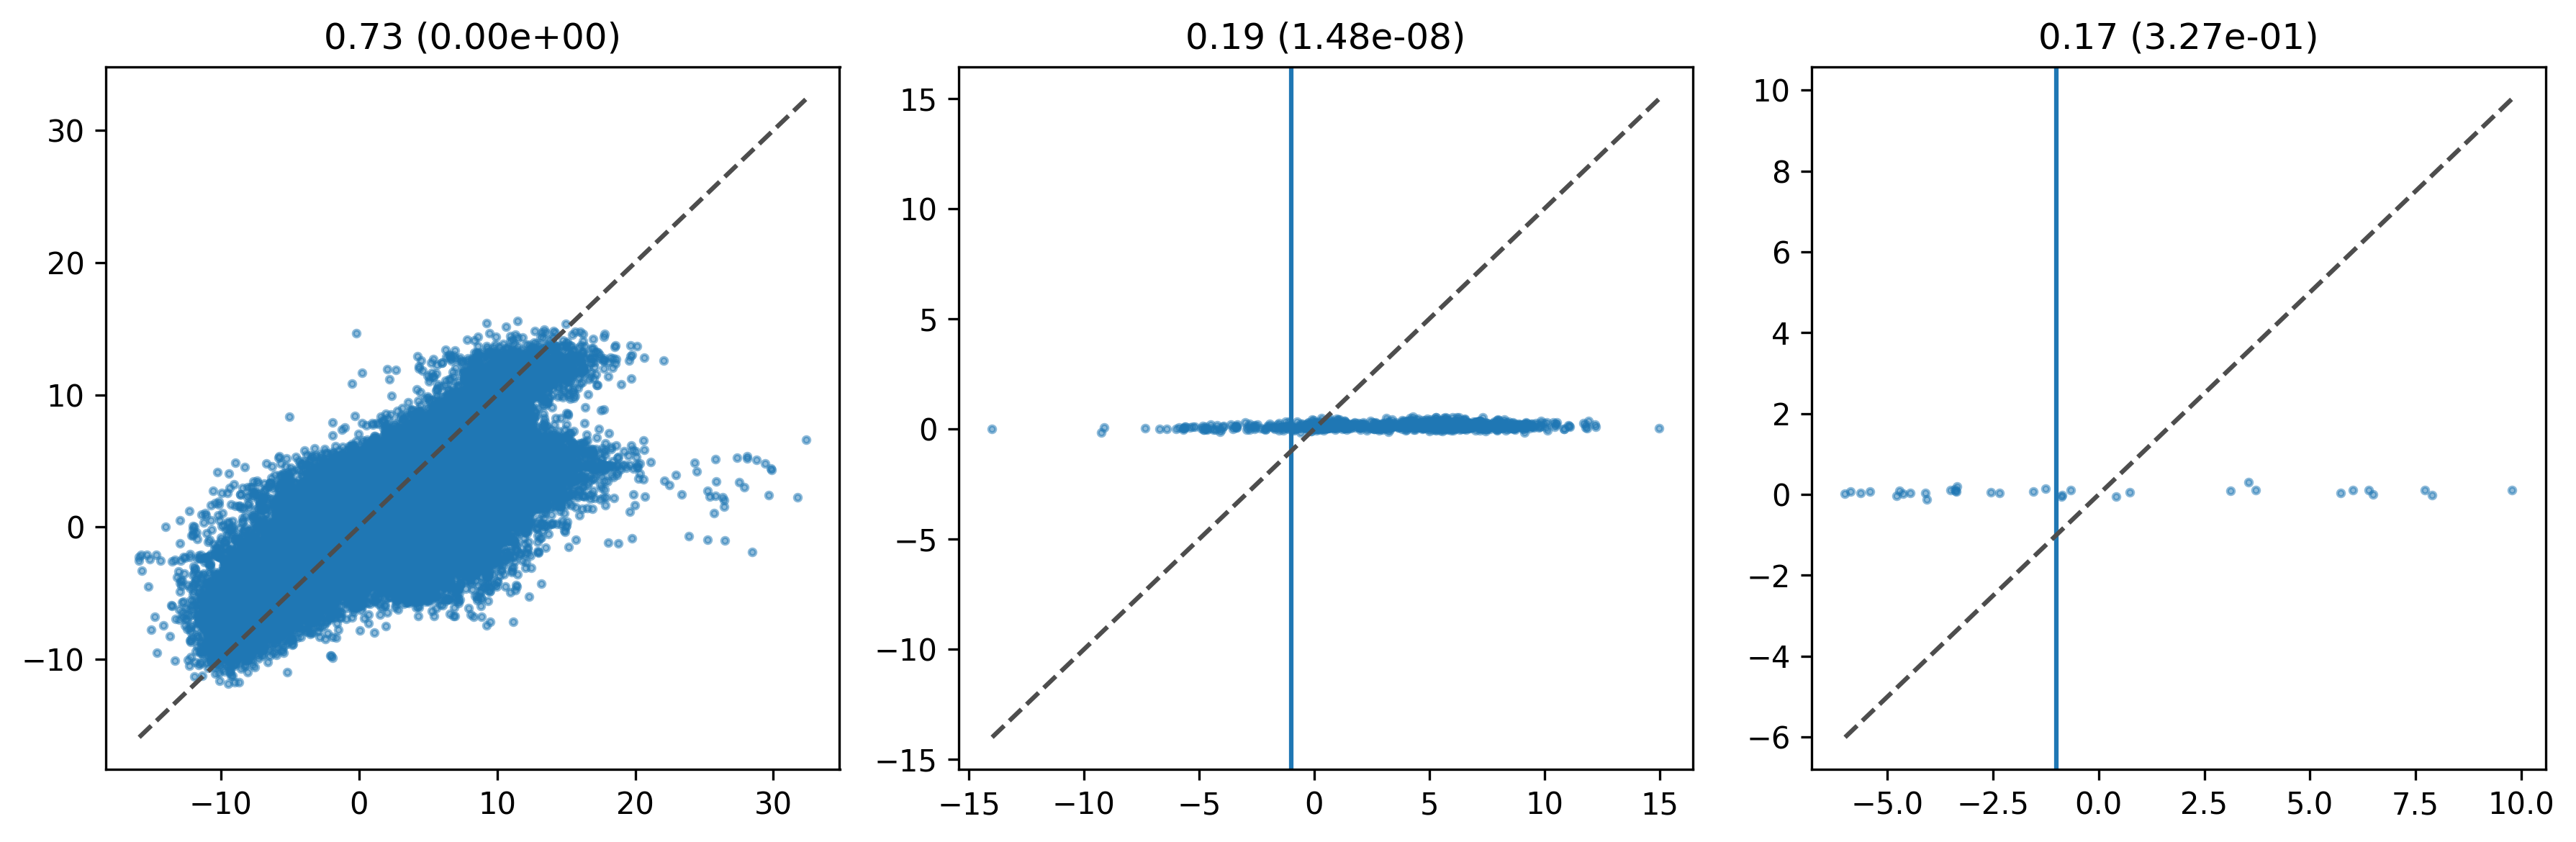

In [143]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=3)

ax = axes[0]
x = np.array(cadrres_output_dict['obs_train_df']).flatten()
y = np.array(cadrres_output_dict['pred_train_df']).flatten()
ax.scatter(x[~np.isnan(x)], y[~np.isnan(x)], s=5, alpha=0.5)

pcor, pval = stats.pearsonr(x[~np.isnan(x)], y[~np.isnan(x)])
ax.set_title("{:.2f} ({:.2e})".format(pcor, pval))

min_val = np.nanmin(x)
max_val = np.nanmax(x)
ax.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")

drug_id = '1032'

ax = axes[1]
x = np.array(cadrres_output_dict['obs_train_df'][[drug_id]]).flatten()
y = np.array(cadrres_output_dict['pred_train_df'][[drug_id]]).flatten()
ax.scatter(x[~np.isnan(x)], y[~np.isnan(x)], s=5, alpha=0.5)
ax.axvline(x=gdsc_drug_df.loc[drug_id, 'log2_max_conc'])
stats.pearsonr(x[~np.isnan(x)], y[~np.isnan(x)])

min_val = np.nanmin(x)
max_val = np.nanmax(x)
ax.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")

pcor, pval = stats.pearsonr(x[~np.isnan(x)], y[~np.isnan(x)])
ax.set_title("{:.2f} ({:.2e})".format(pcor, pval))

ax = axes[2]
x = np.array(cadrres_output_dict['obs_train_df'].loc[indication_sample_list][[drug_id]]).flatten()
y = np.array(cadrres_output_dict['pred_train_df'].loc[indication_sample_list][[drug_id]]).flatten()
ax.scatter(x[~np.isnan(x)], y[~np.isnan(x)], s=5, alpha=0.5)
ax.axvline(x=gdsc_drug_df.loc[drug_id, 'log2_max_conc'])
stats.pearsonr(x[~np.isnan(x)], y[~np.isnan(x)])

min_val = np.nanmin(x)
max_val = np.nanmax(x)
ax.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")

pcor, pval = stats.pearsonr(x[~np.isnan(x)], y[~np.isnan(x)])
ax.set_title("{:.2f} ({:.2e})".format(pcor, pval))

plt.tight_layout()